In [1]:
import numpy as np
from PIL import Image, ImageDraw
import os
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import random
from IPython.display import Image as displayImage

### A dataset with one ring and a set of associated properties (center, radius, thickness, and distortion)

In [2]:
img_size = 28

def create_ring(image_size, center, radius, thickness, deformation=0):
    img = Image.new('L', (image_size, image_size), color=0)
    draw = ImageDraw.Draw(img)
    
    for angle in range(360):
        r = radius + random.uniform(-deformation, deformation)
        x = center[0] + r * np.cos(np.radians(angle))
        y = center[1] + r * np.sin(np.radians(angle))
        draw.ellipse([x-thickness/2, y-thickness/2, x+thickness/2, y+thickness/2], fill=255)
    
    return np.array(img)

def generate_dataset(num_images, image_size=img_size, save_dir='ring_generator_dataset'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    labels = []
    
    for i in range(num_images):
        center = (random.randint(5, image_size-5), random.randint(5, image_size-5))
        radius = random.randint(4, min(center[0], center[1], image_size-center[0], image_size-center[1])-1)
        thickness = random.uniform(0.2, 1.5)#*np.sqrt(radius)
        deformation = random.uniform(0.5, 3)
        
        img = create_ring(image_size, center, radius, thickness, deformation)
        
        img_pil = Image.fromarray(img)
        img_pil.save(f'{save_dir}/ring_image_{i}.png')
        
        # Store the ring properties as a label, now including radius
        label = {
            "center": center,
            "radius": radius,
            "thickness": thickness,
            "deformation": deformation
        }
        labels.append(label)
    
    # Save labels as JSON
    with open(f'{save_dir}/labels.json', 'w') as f:
        json.dump(labels, f, indent=2)

In [3]:
# Generate 50000 images (for this project having a lot of images actually makes a difference!)
generate_dataset(50000)
print("Dataset generated successfully!")

Dataset generated successfully!


### Now let's load the data

In [4]:
def load_single_ring_dataset(directory):
    images = []
    labels = []
    
    # Read labels from JSON file
    with open(os.path.join(directory, 'labels.json'), 'r') as f:
        labels_data = json.load(f)
    
    # Load images and process labels
    for i, label in enumerate(labels_data):
        filename = f'ring_image_{i}.png'
        img_path = os.path.join(directory, filename)
        if os.path.exists(img_path):
            # Load and normalize image
            img = Image.open(img_path).convert('L')
            img_array = np.array(img).reshape(-1).astype('float32') / 255
            images.append(img_array)
            
            # Process label
            processed_label = [
                label['center'][0] / img.width,  # Normalize x coordinate
                label['center'][1] / img.height,  # Normalize y coordinate
                label['radius'] / img.width,  # Normalize radius
                label['thickness'],
                label['deformation']
            ]
            labels.append(processed_label)
        else:
            print(f"Warning: Image {filename} not found. Skipping.")
    
    # Ensure we have the same number of images and labels
    if len(images) != len(labels):
        print(f"Warning: Number of images ({len(images)}) does not match number of labels ({len(labels)})")
    
    return np.array(images), np.array(labels)

In [5]:
images, labels = load_single_ring_dataset('ring_generator_dataset')

In [6]:
img_size = int(np.sqrt(images[0].shape[0]))
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

### How does the data look like?

In [7]:
def visualize_ring_dataset(images, labels, num_samples=5, max_cols=4):
    # Ensure we don't try to display more samples than we have
    num_samples = min(num_samples, len(images))
    
    # Randomly select indices
    selected_indices = random.sample(range(len(images)), num_samples)
    
    # Calculate number of rows and columns
    num_cols = min(num_samples, max_cols)
    num_rows = (num_samples - 1) // num_cols + 1
    
    # Calculate figure size (assuming each subplot is 3x3 inches)
    figsize = (num_cols * 3, num_rows * 3)
    
    # Set up the plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    img_size = int(np.sqrt(images[0].shape[0]))  # Assuming square images
    
    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        
        # Reshape and display the image
        img = images[idx].reshape((img_size, img_size))
        ax.imshow(img, cmap='gray')
        
        # Extract label information
        center_x, center_y, radius, thickness, deformation = labels[idx]
        
        # Denormalize center coordinates and radius
        center_x *= img_size - 1
        center_y *= img_size - 1
        radius *= img_size - 1
        
        # Add a circle to represent the ring
        circle = Circle((center_x, center_y), radius, fill=False, color='red')
        ax.add_patch(circle)
        
        # Add text with ring properties
        ax.text(0.05, 1.3, f"Center: ({center_x:.1f}, {center_y:.1f})\nRadius: {radius:.1f}\nThickness: {thickness:.2f}\nDeformation: {deformation:.2f}",
                transform=ax.transAxes, verticalalignment='top', color='red', fontsize=10)
        
        ax.axis('off')
    
    # Remove any unused subplots
    for i in range(num_samples, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

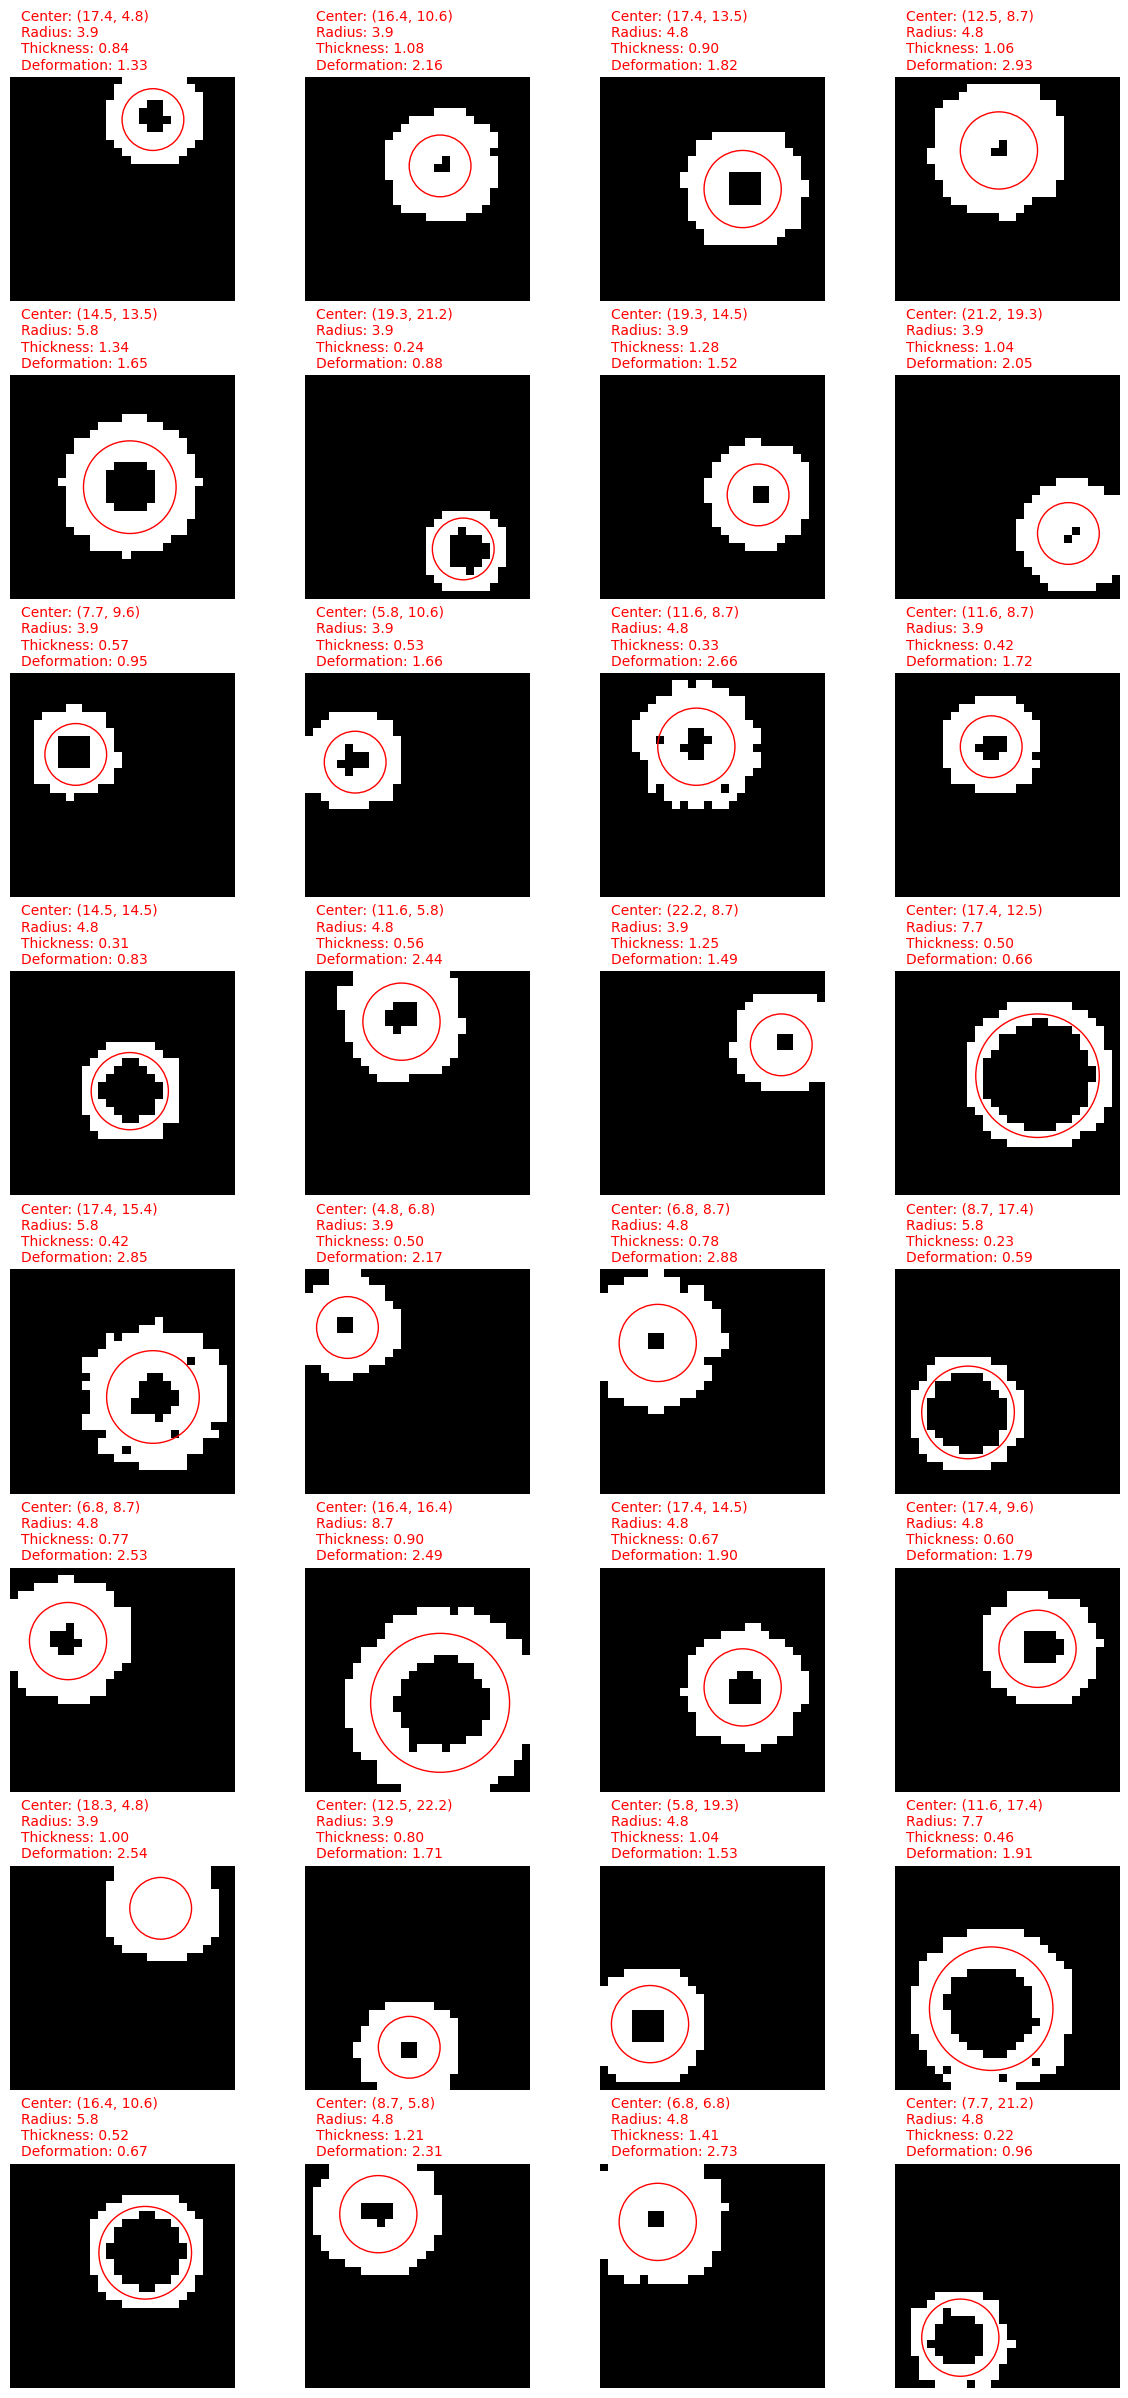

In [8]:
# Visualize some samples
visualize_ring_dataset(images, labels, num_samples=32)

### Can you generate images from the dataset labels using some generative network?

### Below I provide an image of a solution I implemented using a CNN. Can you achieve something similar or better with a simple netowrk?

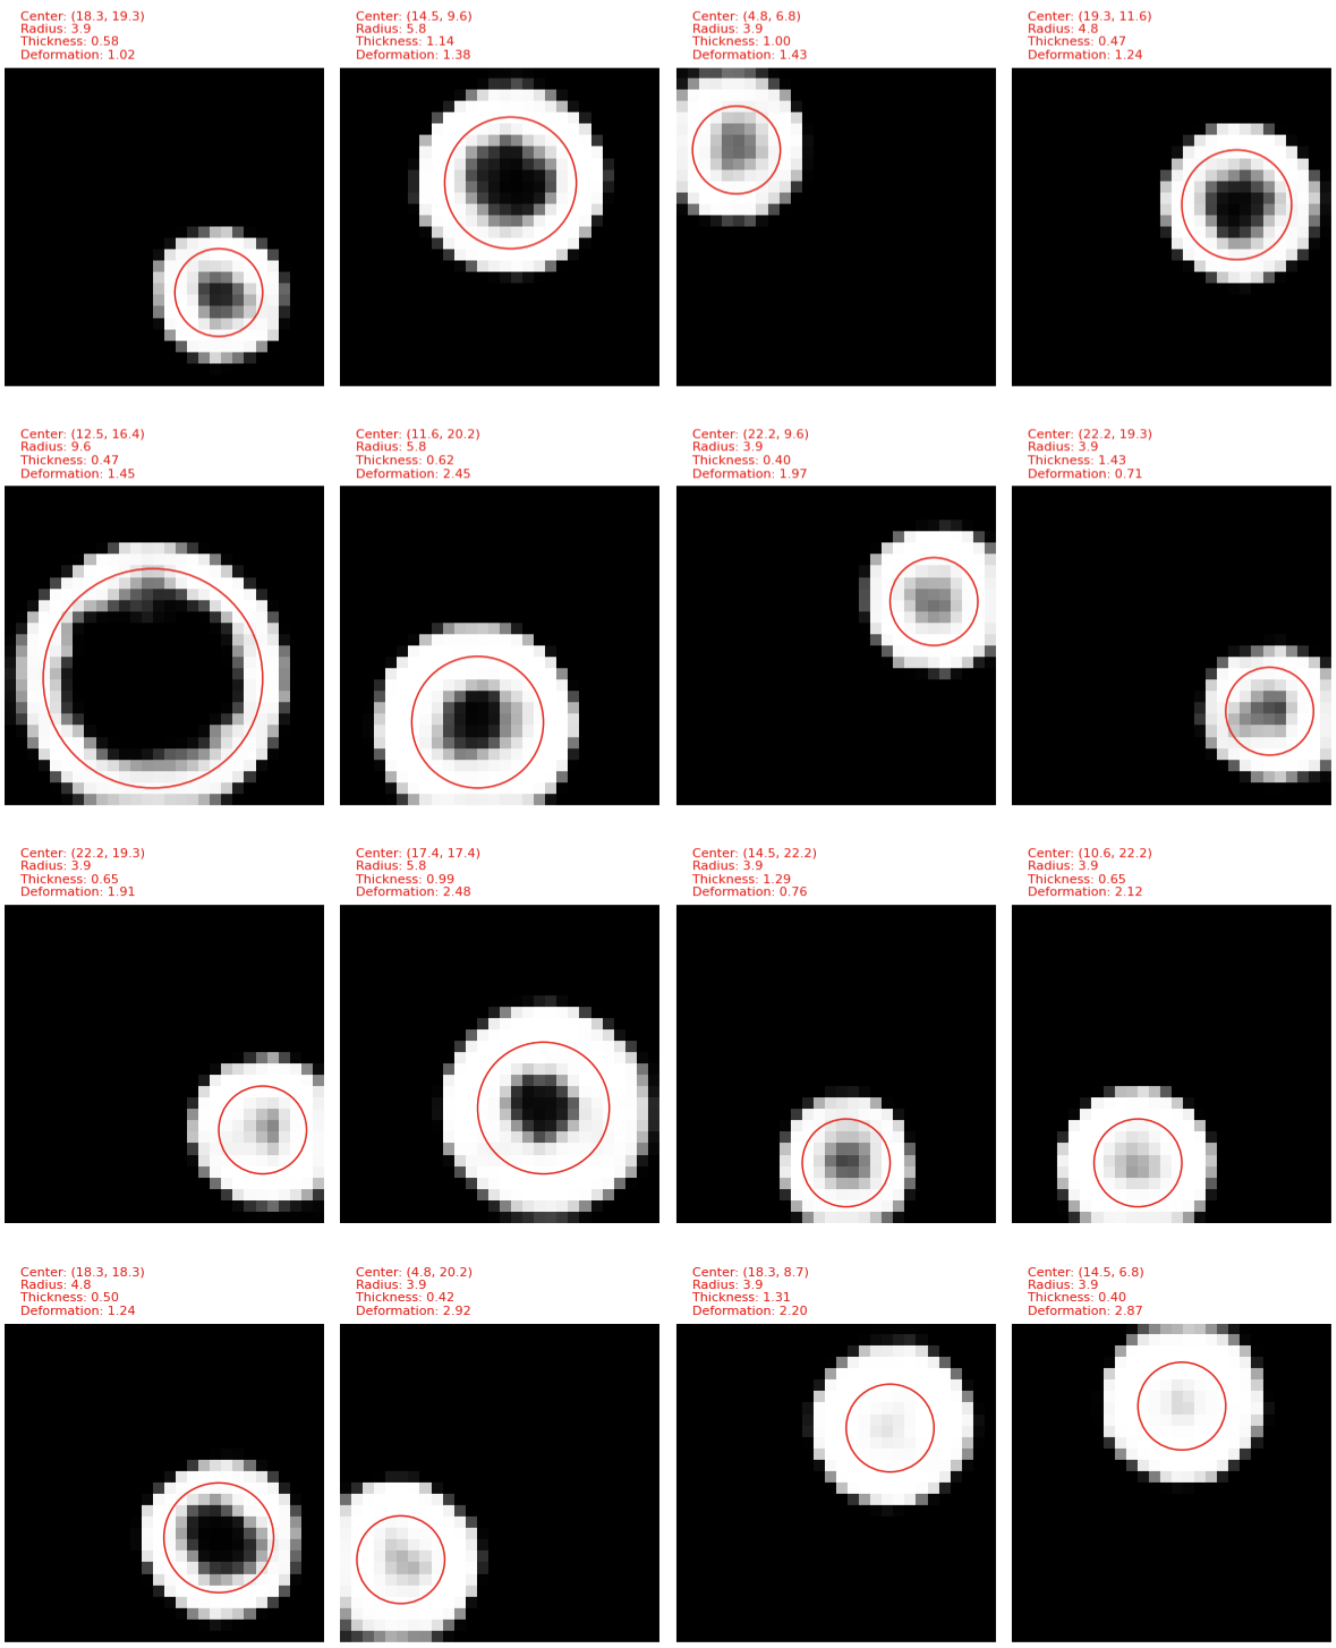

In [9]:
displayImage("tutorial_images/GeneratedRings.png", width=1140)

### Auxiliary code to visualize your solution

In [10]:
def generate_ring_images(generator, labels):
    return generator.predict(labels)

def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

def plot_generated_rings(generator, labels, num_samples=5, max_cols=4):
    num_samples = min(num_samples, len(labels))
    num_cols = min(num_samples, max_cols)
    num_rows = (num_samples - 1) // num_cols + 1
    figsize = (num_cols * 3, num_rows * 3.8)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Randomly select indices
    random_indices = np.random.choice(len(labels), num_samples, replace=False)
    selected_labels = labels[random_indices]
    
    generated_images = generate_ring_images(generator, selected_labels)
    img_size = generated_images.shape[1]
    
    for i in range(num_samples):
        ax = axes[i]
        img = generated_images[i].reshape((img_size, img_size))
        ax.imshow(img, cmap='gray')
        
        center_x, center_y, radius, thickness, deformation = selected_labels[i]
        center_x *= img_size - 1
        center_y *= img_size - 1
        radius *= img_size - 1
        
        circle = Circle((center_x, center_y), radius, fill=False, color='red')
        ax.add_patch(circle)
        
        ax.text(0.05, 1.18, f"Center: ({center_x:.1f}, {center_y:.1f})\n"
                           f"Radius: {radius:.1f}\n"
                           f"Thickness: {thickness:.2f}\n"
                           f"Deformation: {deformation:.2f}",
                transform=ax.transAxes, verticalalignment='top', color='red', fontsize=8)
        
        ax.axis('off')
    
    for i in range(num_samples, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

### How does the performance of the model change with increasing & decreasing number of training examples?

### We are using a deterministic generative network but one of our parameters is not deterministic. Can you think of alternative to more closely resemble our ring examples?
HINT: Explore VAEs for this task.